In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# Correct path - files are in the SAME DIRECTORY as notebook
RAW = Path(".")

# Read files
qos = pd.read_csv(RAW / "network_qos.csv")
usage = pd.read_csv(RAW / "usage.csv")
revenue = pd.read_csv(RAW / "revenue.csv")
complaints = pd.read_csv(RAW / "complaints.csv")

# Merge datasets
df = (qos
      .merge(usage, on="region", how="left")
      .merge(revenue, on="region", how="left")
      .merge(complaints, on="region", how="left"))

# Fill missing values
df.fillna({
    "signal_strength": df["signal_strength"].mean(),
    "latency_ms": df["latency_ms"].mean(),
    "throughput_mbps": df["throughput_mbps"].mean(),
    "complaints": 0
}, inplace=True)

# Save master file in SAME folder
df.to_csv("network_master.csv", index=False)
print("✅ Clean dataset saved as: network_master.csv")

df.head()


✅ Clean dataset saved as: network_master.csv


,region,signal_strength,latency_ms,throughput_mbps,outages,data_gb,call_minutes,dropped_calls,ARPU,customer_count,complaints,month
0,Delhi,-70,25,35,2,250,300000,100,320,56000,110,Aug
1,Mumbai,-65,20,42,1,270,290000,90,400,64000,95,Aug
2,Chennai,-75,28,32,3,220,270000,120,280,49000,140,Aug
3,Kolkata,-72,30,30,2,180,260000,130,250,45000,150,Aug
4,Hyderabad,-68,22,40,1,260,275000,110,380,51000,100,Aug


In [3]:
df = pd.read_csv("network_master.csv")
print(df.describe())

       signal_strength  latency_ms  throughput_mbps  outages     data_gb  \
count         5.000000    5.000000         5.000000  5.00000    5.000000   
mean        -70.000000   25.000000        35.800000  1.80000  236.000000   
std           3.807887    4.123106         5.118594  0.83666   36.469165   
min         -75.000000   20.000000        30.000000  1.00000  180.000000   
25%         -72.000000   22.000000        32.000000  1.00000  220.000000   
50%         -70.000000   25.000000        35.000000  2.00000  250.000000   
75%         -68.000000   28.000000        40.000000  2.00000  260.000000   
max         -65.000000   30.000000        42.000000  3.00000  270.000000   

        call_minutes  dropped_calls        ARPU  customer_count  complaints  
count       5.000000       5.000000    5.000000        5.000000    5.000000  
mean   279000.000000     110.000000  326.000000    53000.000000  119.000000  
std     15968.719423      15.811388   63.874878     7314.369419   24.596748  
min

# Correlation Analysis

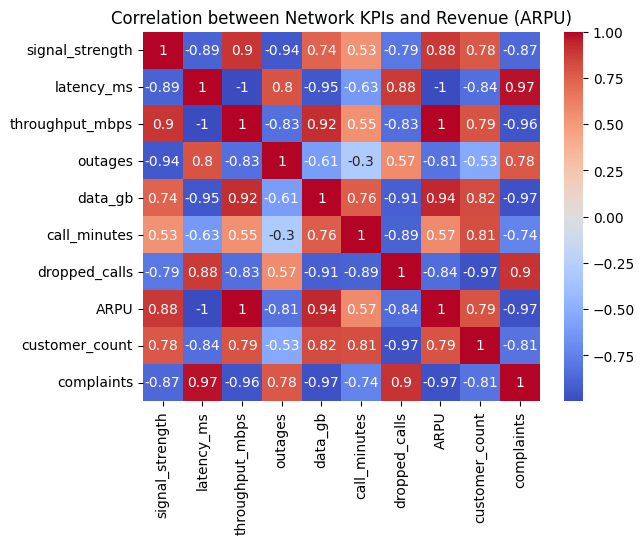

In [4]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation between Network KPIs and Revenue (ARPU)")
plt.show()

# ARPU vs Latency

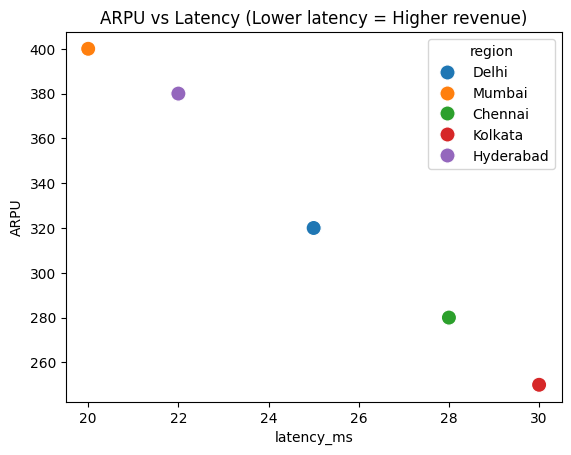

In [5]:
sns.scatterplot(x="latency_ms", y="ARPU", data=df, hue="region", s=120)
plt.title("ARPU vs Latency (Lower latency = Higher revenue)")
plt.show()


# Complaints per Region

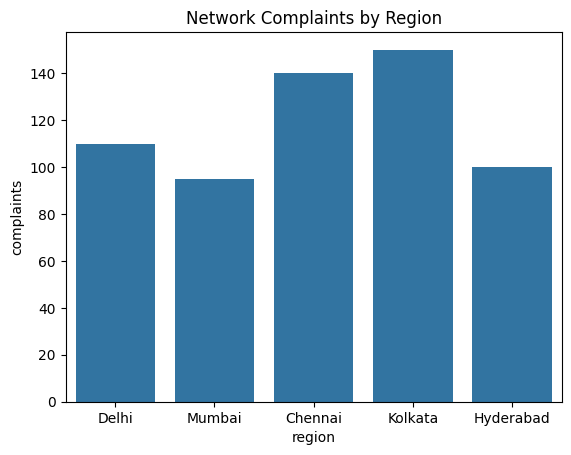

In [6]:
sns.barplot(x="region", y="complaints", data=df)
plt.title("Network Complaints by Region")
plt.show()



In [8]:
df = pd.read_csv("network_master.csv")

X = df[["latency_ms", "throughput_mbps", "complaints", "data_gb", "outages"]]
y = df["ARPU"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
acc_lr = 1 - (mae_lr / y_test.mean())   # Regression accuracy

print("Linear Regression R²:", r2_lr)
print("MAE:", mae_lr)
print("Accuracy:", acc_lr)

Linear Regression R²: -25.699353776885893
MAE: 51.41069589970323
Accuracy: 0.8681777028212738


# Decision Tree Regressor

In [12]:
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
acc_dt = 1 - (mae_dt / y_test.mean())   # Regression accuracy

print("Decision Tree R²:", r2_dt)
print("MAE:", mae_dt)
print("Accuracy:", acc_dt)

Decision Tree R²: -49.0
MAE: 70.0
Accuracy: 0.8205128205128205


# Compare Models

In [13]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree"],
    "R2_Score": [r2_lr, r2_dt],
    "MAE": [mae_lr, mae_dt],
    "Accuracy": [acc_lr, acc_dt]
})

print(results)

               Model   R2_Score        MAE  Accuracy
0  Linear Regression -25.699354  51.410696  0.868178
1      Decision Tree -49.000000  70.000000  0.820513


# Predict “At Risk” Regions (Classification)


In [17]:
# Create binary label: 1 = low ARPU, 0 = normal/high
df["low_revenue_flag"] = np.where(df["ARPU"] < df["ARPU"].median(), 1, 0)

X = df[["latency_ms","throughput_mbps","complaints","outages","data_gb"]]
y = df["low_revenue_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
[[2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11464\2453792561.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot1 = df.pivot_table(


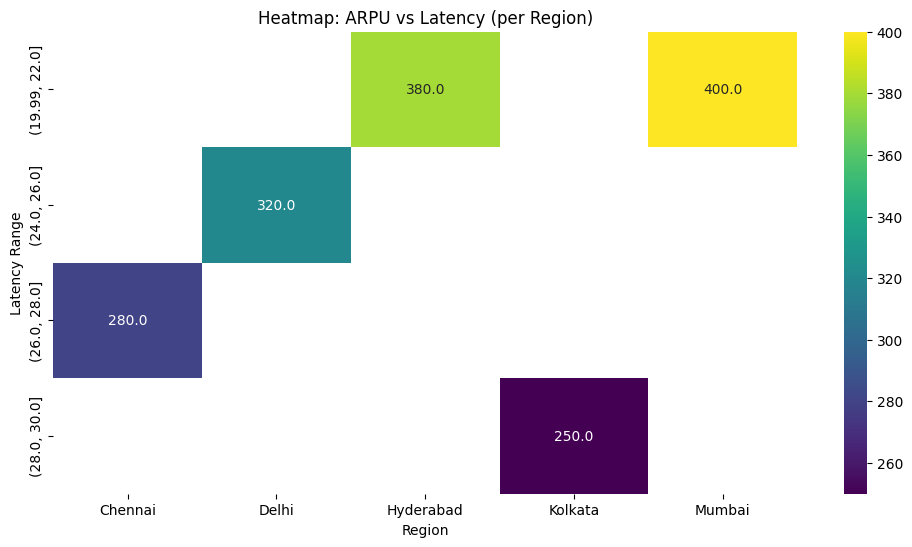

<Figure size 640x480 with 0 Axes>

Saved: heatmap_arpu_latency.png


In [24]:
# Create latency bins (5 groups)
df["latency_bin"] = pd.cut(df["latency_ms"], bins=5)

pivot1 = df.pivot_table(
    values="ARPU",           # <-- Correct column name
    index="latency_bin",
    columns="region",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot1, annot=True, fmt=".1f", cmap="viridis")
plt.title("Heatmap: ARPU vs Latency (per Region)")
plt.xlabel("Region")
plt.ylabel("Latency Range")
plt.show()

# Save in SAME folder
plt.savefig("heatmap_arpu_latency.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: heatmap_arpu_latency.png")


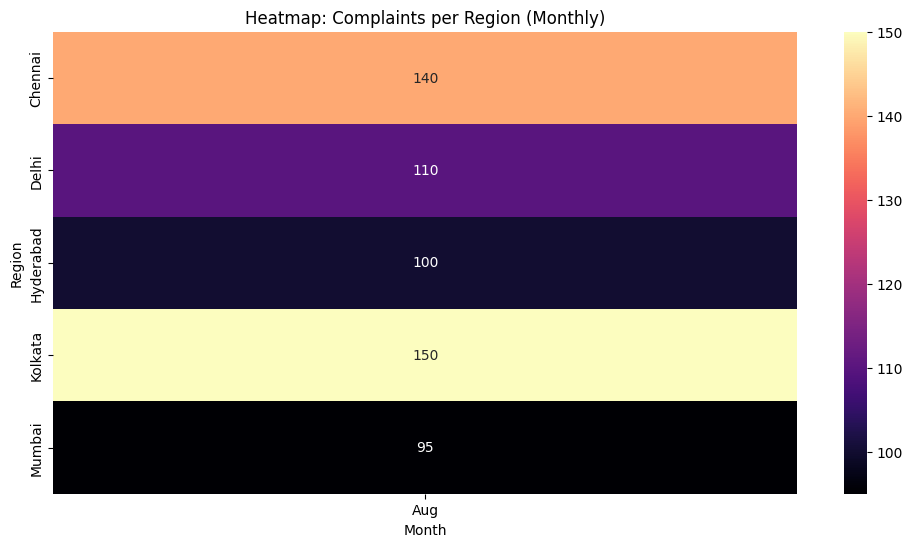

<Figure size 640x480 with 0 Axes>

Saved: heatmap_complaints_region.png


In [25]:
pivot2 = df.pivot_table(
    values="complaints",
    index="region",
    columns="month",
    aggfunc="sum"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot2, annot=True, fmt=".0f", cmap="magma")
plt.title("Heatmap: Complaints per Region (Monthly)")
plt.xlabel("Month")
plt.ylabel("Region")
plt.show()

# Save in SAME folder
plt.savefig("heatmap_complaints_region.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: heatmap_complaints_region.png")
